In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time

In [2]:
# Position
x0 = 0
xf = np.array([-15, 15])
xobs = [[-14, -13], [-6, -5.5], [4, 5.5], [10, 11.5]]


In [35]:
# General RRT Settings
K = 1000
iter_max = 1
tMax = 20
vmax = 2

In [4]:
# Obstacle Setting
# [start, close, open]
obs1 = [0, 5, 2]
obs2 = [0, 4, 1]
obs3 = [0, 3, 3.5]
obs4 = [0, 4, 3]
obs_vec = [obs1, obs2, obs3, obs4]

False


In [111]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

In [5]:
def distance(a, b):
    return b - a

In [6]:
def random_sample():
    trand = rn.uniform(1e-1, tMax)
    """sign = 0
    if rn.random() < 0.5:
        sign = 1
    else:
        sign = -1
    xrand = sign*rn.uniform(0, trand*vmax+x0)"""
    check = rn.uniform(0, 1)
    
    if check >= 0 and check < 0.9:
        xrand = rn.uniform(trand*(-vmax)+x0, trand*vmax+x0)
    elif check >= 0.9:
        xrand = xf[1]
        trand = xf[1]
    qrand = [xrand, trand]
    return qrand

In [7]:
def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

In [8]:
def check_route(qclosest, qnew):
    route_check = []
    div = 10000
    tspace = np.linspace(0, 1, div)
    for t in tspace:
        xmove = (qnew[0]-qclosest[0])/div*t
        tmove = (qnew[1]-qclosest[1])/div*t
        qcheck = [qclosest[0]+xmove, qclosest[1]+tmove]
        check_vec = validate(qcheck)

        if np.sum(check_vec) == 0:
            route_check.append(0)
        else:
            return False

    if np.sum(route_check) == 0:
        return True # No Path Collision
    else:
        return False # Path Collision

In [9]:
def reachable(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    if dx == 0:
        return True
    else:
        if dt > 0 and np.abs(dx/dt) <= vmax:
            return True
        else:
            return False

In [10]:
def find_neighbor(qrand, V):
    # Find neighbor
    dist_vec = []
    for i in range(len(V)):
        if reachable(V[i], qrand):
            dist_vec.append(distance(V[i][0], qrand[0]))
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [11]:
def extend(qclosest, q1):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    norm = np.sqrt(dx**2 + dt**2)
    dxnorm = dx/norm*vmax
    dtnorm = dt/norm*vmax
    #qnew = [qclosest[0]+dxnorm*vmax, qclosest[1]+dtnorm*vmax]
    qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [93]:
def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [96]:
# Standard RRT
time_vec = []
iter = 0
K = 1000

while iter < iter_max:
    start = time.time()
    k = 0
    V_RRT = []
    V_RRT.append([x0, 0])
    V_RRT_raw = []
    T_RRT = []
    T_RRT.append(0)
    E_RRT = []
    sanity = []
    path_RRT = None
    #while k < K:
    while 1:
        print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRT)
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0 and check_route(qclosest, qnew):
                    break

        # Add V, E
        k += 1
        #print('qrand: ', qrand)
        #print('qnew: ', qnew)
        V_RRT.append(qnew)
        sanity.append(qrand)
        V_RRT_raw.append(qrand)
        E_RRT.append([qclosest, qnew])
        T_RRT.append(qnew[1])

        # Check continue
        dist_check = []
        for i in range(len(xf)):
            if np.abs(distance(xf[i], qnew[0])) <= 1:
                dist_check.append(1)
            else:
                dist_check.append(0)
        print('dist to xf: ', np.abs(distance(xf[1], qnew[0])))
        print('dist_check sum: ', np.sum(dist_check))
        if np.sum(dist_check) > 0 or k > K:
            end_cond = dist_check.index(1)
            dist_to_fin = distance(xf[i], qnew[0])
            qfin = [xf[end_cond], qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRT.append(qfin)
            E_RRT.append([qnew, qfin])
            break
    path_RRT = find_path(xf, E_RRT)
    end = time.time()
    
    time_vec.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec)/len(time_vec))

k:  0
dist to xf:  13.441871787230733
dist_check sum:  0
k:  1
dist to xf:  11.815432161636384
dist_check sum:  0
k:  2
dist to xf:  10.813287963366271
dist_check sum:  0
k:  3
dist to xf:  12.571577356854583
dist_check sum:  0
k:  4
dist to xf:  10.718265225851914
dist_check sum:  0
k:  5
dist to xf:  14.767252178136623
dist_check sum:  0
k:  6
dist to xf:  10.041100188835756
dist_check sum:  0
k:  7
dist to xf:  10.62124104749531
dist_check sum:  0
k:  8
dist to xf:  14.81971540592428
dist_check sum:  0
k:  9
dist to xf:  16.706635499876974
dist_check sum:  0
k:  10
dist to xf:  13.294397570302596
dist_check sum:  0
k:  11
dist to xf:  13.573866450574384
dist_check sum:  0
k:  12
dist to xf:  11.008335603757068
dist_check sum:  0
k:  13
dist to xf:  16.298319614572648
dist_check sum:  0
k:  14
dist to xf:  16.74075834732151
dist_check sum:  0
k:  15
dist to xf:  8.567428797514221
dist_check sum:  0
k:  16
dist to xf:  13.527552809175578
dist_check sum:  0
k:  17
dist to xf:  10.25595

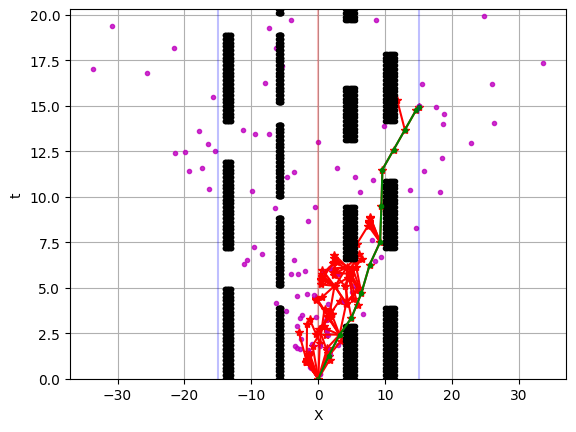

In [129]:
fig = plt.figure()
ax = fig.subplots()
# RRT
for rrtv in V_RRT:
    plt.plot(rrtv[0], rrtv[1], 'r*')
for rrtvrnd in V_RRT_raw:
    plt.plot(rrtvrnd[0], rrtvrnd[1], 'm.', alpha=0.8)
for rrte in E_RRT:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)

# Obstacle
tspace = np.linspace(0, max(T_RRT)+5, 100)
for xobsi in range(len(xobs)):
    xobs_this = xobs[xobsi]
    xspace = np.linspace(xobs_this[0], xobs_this[1], 10)
    for xi in xspace:
        for ti in tspace:
            if not obstacle_check(ti, obs_vec[xobsi]):
                plt.plot(xi, ti, 'k.')#, alpha=0.25)

# Path
for pathi in path_RRT:
    plt.plot(pathi[0], pathi[1], '.g')
for pathi in range(len(path_RRT)-1):
    plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')

# Initial/Final
plt.plot([x0, x0], [0, max(T_RRT)+5], 'r-', alpha=0.25)
for i in range(len(xf)):
    plt.plot([xf[i], xf[i]], [0, max(T_RRT)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf[1]+1)
plt.ylim(0, max(T_RRT)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()

In [ ]:
# Save files
save = False

if save:
    import pickle
            
    RRT = {}
    RRT['V'] = V_RRT
    RRT['E'] = E_RRT
    RRT['T'] = T_RRT

    with open("RRT", "wb") as fp:   #Pickling
        pickle.dump(RRT, fp)

In [99]:
def neighbors(q0, V_RRTstar):
    prox = [2.5, 2.5] # [x, t]
    output = []
    for v in V_RRTstar:
        if 0 <= q0[0]-v[0] <= prox[0] and 0 <= q0[1]-v[1] <= prox[1] and reachable(v, q0):
            output.append(v)
    return output

In [102]:
# Stardard RRT*
time_vec_star = []
iter = 0

while iter < iter_max:
    start = time.time()
    k = 0
    V_RRTstar = []
    V_RRTstar.append([x0, 0])
    T_RRTstar = []
    T_RRTstar.append(0)
    E_RRTstar = []
    while k < K:
        print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRTstar)
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew):
                        break

        # Add V, E
        k += 1
        V_RRTstar.append(qnew)
        E_RRTstar.append([qclosest, qnew])
        T_RRTstar.append(qnew[1])

        # Rewiring
        if k > 1:
            qmin = qclosest
            cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
            neighbor_vector = neighbors(qnew, V_RRTstar)
            if len(neighbor_vector) > 0:
                for v in neighbor_vector:
                    print('Is it Valid?: ', check_route(v, qnew))
                    if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                        cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                        qmin = v
                E_RRTstar.append([qnew, qmin])

        # Check continue
        dist_check = []
        for i in range(len(xf)):
            if np.abs(distance(xf[i], V_RRTstar[-1][0])) <= 1:
                dist_check.append(1)
            else:
                dist_check.append(0)
        if np.sum(dist_check) > 0 or k > K:
            end_cond = dist_check.index(1)
            dist_to_fin = distance(xf[i], qnew[0])
            qfin = [xf[end_cond], qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRTstar.append(qfin)
            E_RRTstar.append([qnew, qfin])
            break
    path_RRTstar = find_path(xf, E_RRTstar)
    end = time.time()
    
    time_vec_star.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec_star)/len(time_vec_star))

k:  0
k:  1
Is it Valid?:  True
k:  2
Is it Valid?:  True
Is it Valid?:  True
k:  3
Is it Valid?:  True
Is it Valid?:  True
k:  4
Is it Valid?:  True
Is it Valid?:  True
Is it Valid?:  True
k:  5
Is it Valid?:  True
Is it Valid?:  True
k:  6
Is it Valid?:  True
k:  7
Is it Valid?:  True
Is it Valid?:  True
Is it Valid?:  True
k:  8
Is it Valid?:  True
Is it Valid?:  True
k:  9
Is it Valid?:  True
Is it Valid?:  True
k:  10
Is it Valid?:  True
Is it Valid?:  True
k:  11
Is it Valid?:  True
k:  12
Is it Valid?:  True
Is it Valid?:  True
k:  13
Is it Valid?:  True
Is it Valid?:  True
k:  14
Is it Valid?:  True
k:  15
Is it Valid?:  True
Is it Valid?:  True
k:  16
Is it Valid?:  True
Is it Valid?:  True
k:  17
Is it Valid?:  True
Is it Valid?:  True
Is it Valid?:  True
k:  18
Is it Valid?:  True
k:  19
Is it Valid?:  True
Is it Valid?:  True
Is it Valid?:  True
k:  20
Is it Valid?:  True
Is it Valid?:  True
Is it Valid?:  True
k:  21
Is it Valid?:  True
Is it Valid?:  True
k:  22
Is it Val

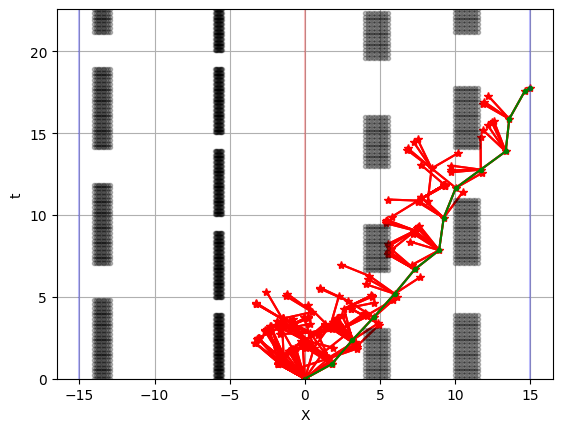

In [128]:
fig = plt.figure()
ax = fig.subplots()
# RRTstar
for rrtv in V_RRTstar:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrte in E_RRTstar:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)

# Obstacle
tspace = np.linspace(0, max(T_RRTstar)+5, 100)
for xobsi in range(len(xobs)):
    xobs_this = xobs[xobsi]
    xspace = np.linspace(xobs_this[0], xobs_this[1], 10)
    for xi in xspace:
        for ti in tspace:
            if not obstacle_check(ti, obs_vec[xobsi]):
                plt.plot(xi, ti, 'k.', alpha=0.25)

# Path
for pathi in path_RRTstar:
    plt.plot(pathi[0], pathi[1], '.g')
for pathi in range(len(path_RRTstar)-1):
    plt.plot([path_RRTstar[pathi][0], path_RRTstar[pathi+1][0]], [path_RRTstar[pathi][1], path_RRTstar[pathi+1][1]], '-g')


# Initial/Final
plt.plot([x0, x0], [0, max(T_RRTstar)+5], 'r-', alpha=0.25)
for i in range(len(xf)):
    plt.plot([xf[i], xf[i]], [0, max(T_RRTstar)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf[1]+1)
plt.ylim(0, max(T_RRTstar)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()

In [ ]:
save = False

if save:
    import pickle
        
    RRTstar_data = {}
    RRTstar_data['V'] = V_RRTstar
    RRTstar_data['E'] = E_RRTstar
    RRTstar_data['T'] = T_RRTstar

    with open("RRTstar", "wb") as fp:   #Pickling
        pickle.dump(RRTstar_data, fp)
    
    """with open("RRT", "rb") as fp:   # Unpickling
    b = pickle.load(fp)"""

In [42]:
def reachable_RRTC(q0, q1, k):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]

    if dx == 0:
        return True
    else:
        """if np.mod(k,2) == 0:
            if dt > 0 and np.abs(dx/dt) <= vmax:
                return True
            else:
                return False
        else:
            if dt < 0 and np.abs(dx/dt) <= vmax:
                return True
            else:
                return False"""
        if np.abs(dx/dt) <= vmax:
            return True
        else:
            return False

In [139]:
def random_sample_RRTC(tf, k):
    while 1:
        check = rn.uniform(0, 1)
        trand = rn.uniform(1e-1, tf)
        if np.mod(k, 2) == 0:
            if check >= 0 and check < 0.9:
                xrand = rn.uniform(trand*(-vmax)+x0, trand*vmax+x0)
            else:
                xrand = xf[1]
                trand = tf
        else:
            if check >= 0 and check < 0.9:
                xrand = rn.uniform(-(tf-trand)*vmax, (tf-trand)*vmax)+xf[1]
                trand = tf - trand
            else:
                xrand = x0
                trand = 0
        qrand = [xrand, trand]
        if reachable_RRTC([x0, 0], qrand, k) and reachable_RRTC([xf[1], tf], qrand, k):
            break
    return qrand

In [44]:
def find_neighbor_RRTC(qrand, V, k):
    # Find neighbor
    dist_vec = []
    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, k):
            dist_vec.append(distance(V[i][0], qrand[0]))
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [140]:
# Standard ST-RRT-Connect
time_vec_RRTC = []
iter = 0
tf = 20

while iter < iter_max:
    start = time.time()
    V_RRTConnect = {}
    E_RRTConnect = {}
    kk = 0
    while 1:
        tmax = tf
        print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf[1], tf])
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        while k < K:
            print('k: ', k)
            while 1:
                # Sample
                qrand = random_sample_RRTC(tf, k)
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
                    
                if qclosest is not None:
                    qnew = extend(qclosest, qrand)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0:
                        if check_route(qclosest, qnew):
                            break

            # Add V, E
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)
            k += 1

            # Check continue
            dist_check = []
            for i in range(len(xf)):
                if np.abs(distance(V_RRTCa[-1][0], V_RRTCb[-1][0])) <= 1:
                    dist_check.append(1)
                else:
                    dist_check.append(0)
            if np.sum(dist_check) > 0 or k > K:
                E_RRTCa.append([V_RRTCa[-1], V_RRTCb[-1]])
                E_RRTC = []
                E_RRTC.append(E_RRTCa)
                E_RRTC.append(E_RRTCb)
                # Compute Path
                # path = find_path(xf[1], E_RRTC)

                # # Rewiring from xf
                # qmin = qclosest
                # cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
                # neighbor_vector = neighbors(qnew, V_RRTstar)
                # if len(neighbor_vector) > 0:
                #     for v in neighbor_vector:
                #         if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                #             cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                #             qmin = v
                #     E_RRTstar.append([qnew, qmin])
                # break
        V_RRTConnect[str(kk)] = [V_RRTCa, V_RRTCb]
        E_RRTConnect[str(kk)] = [E_RRTCa, E_RRTCb]

        if tf >= 40:
            break
        tf += 5
        kk += 1

    end = time.time()
    
    time_vec_RRTC.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec_RRTC)/len(time_vec_RRTC))

tf:  20
k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
k:  71
k:  72
k:  73
k:  74
k:  75
k:  76
k:  77
k:  78
k:  79
k:  80
k:  81
k:  82
k:  83
k:  84
k:  85
k:  86
k:  87
k:  88
k:  89
k:  90
k:  91
k:  92
k:  93
k:  94
k:  95
k:  96
k:  97
k:  98
k:  99
k:  100
k:  101
k:  102
k:  103
k:  104
k:  105
k:  106
k:  107
k:  108
k:  109
k:  110
k:  111
k:  112
k:  113
k:  114
k:  115
k:  116
k:  117
k:  118
k:  119
k:  120
k:  121
k:  122
k:  123
k:  124
k:  125
k:  126
k:  127
k:  128
k:  129
k:  130
k:  131
k:  132
k:  133
k:  134
k:  135
k:  136
k:  13

In [ ]:
path = find_path(xf[1], E_RRTC)

Text(0, 0.5, 't')

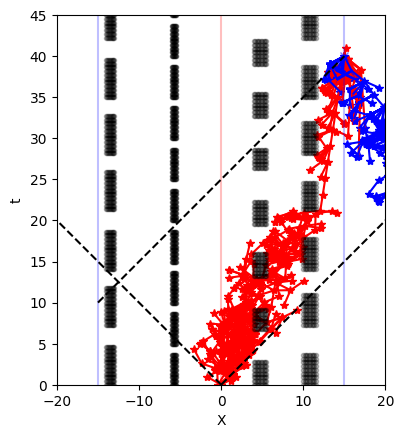

In [141]:
fig = plt.figure()
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrtv in V_RRTCb:
   plt.plot(rrtv[0], rrtv[1], 'b*')
# for rrtvr in V_RRTCb_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'm.')
for rrte in E_RRTCa:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)
for rrte in E_RRTCb:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-')#, alpha=0.25)


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for xobsi in range(len(xobs)):
    xobs_this = xobs[xobsi]
    xspace = np.linspace(xobs_this[0], xobs_this[1], 10)
    for xi in xspace:
        for ti in tspace:
            if not obstacle_check(ti, obs_vec[xobsi]):
                plt.plot(xi, ti, 'k.', alpha=0.25)

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf[1], tf, 'xb', alpha=0.5)
for i in range(len(xf)):
    plt.plot([xf[i], xf[i]], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
plt.plot([0, tf+5], [0, tf+5], '--k')
plt.plot([0, -(tf+5)], [0, tf+5], '--k')
plt.plot([-xf[1], xf[1]], [tf-2*xf[1], tf], '--k')
#plt.plot([xf[1], xf[1]+5], [tf-2*xf[1], tf], '--k')

# Plot Limits
ax.axis('square')
plt.xlim(xf[0]-5, xf[1]+5)
plt.ylim(0, tf+5)
plt.xlabel('X')
plt.ylabel('t')


In [ ]:
def obstacle_check_timeshadow(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

In [ ]:
def validate_timeshadow(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check_timeshadow(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

In [ ]:
# Standard ST-RRT-Connect with Time-Shadow Effect
tf = 20
V_RRTConnect_ts = {}
E_RRTConnect_ts = {}
kk = 0
while 1:
    k = 0
    V_RRTCa_ts = []
    V_RRTCa_ts.append([x0, 0])
    V_RRTCb_ts = []
    V_RRTCb_ts.append([xf[1], tf])
    V_RRTCb_raw_ts = []

    T_RRTCa_ts = []
    T_RRTCb_ts = []
    T_RRTCa_ts.append(0)
    T_RRTCa_ts.append(tf)

    E_RRTCa_ts = []
    E_RRTCb_ts = []

    while k < K:
        print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample_RRTC(tf, k)
            if np.mod(k, 2) == 0:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
            else:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
                
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                    
                # Validate
                check_vec = validate_timeshadow(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew):
                        break

        # Add V, E
        if np.mod(k, 2) == 0:
            V_RRTCa_ts.append(qnew)
            E_RRTCa_ts.append([qclosest, qnew])
            T_RRTCa_ts.append(qnew[1])
        else:
            V_RRTCb_ts.append(qnew)
            E_RRTCb_ts.append([qclosest, qnew])
            T_RRTCb_ts.append(qnew[1])
            V_RRTCb_raw_ts.append(qrand)
        k += 1

        # Check continue
        dist_check = []
        for i in range(len(xf)):
            if np.abs(distance(V_RRTCa_ts[-1][0], V_RRTCb_ts[-1][0])) <= 1:
                dist_check.append(1)
            else:
                dist_check.append(0)
        if np.sum(dist_check) > 0 or k > K:
            E_RRTCa.append([V_RRTCa_ts[-1], V_RRTCb_ts[-1]])
            break
    V_RRTConnect_ts[str(kk)] = [V_RRTCa_ts, V_RRTCb_ts]
    E_RRTConnect_ts[str(kk)] = [E_RRTCa_ts, E_RRTCb_ts]
    
    if tf >= 25:
        break
    tf += 5
    kk += 1

In [ ]:
# TODO
# 1. Do Monte-Carlo for 1000-times and record time for average length
# 2. Add in time-shadow effect on ST-RRT*